<a href="https://colab.research.google.com/github/shreya2118/Customer_segmentation/blob/main/E_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import datetime as dt

# 1. Load Data
df = pd.read_csv('Online_Retail.csv', encoding='ISO-8859-1')

# Convert 'InvoiceDate' to datetime so we can do math with it
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2. Data Cleaning
# Drop rows with no CustomerID and remove cancelled transactions (negative Quantity)
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

# 3. Feature Engineering
# Create a TotalPrice column (Quantity * UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 4. Set a reference date (simulate doing this analysis the day after the last recorded purchase)
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# 5. Calculate RFM Metrics
# Group by CustomerID and aggregate
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                  # Frequency
    'TotalPrice': 'sum'                                    # Monetary
})

# Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


using k-means clustering

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# 1. Log Transformation (handle skewness)
rfm_log = np.log(rfm + 1) # +1 to handle zeros if any

# 2. Standardization
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)

# 3. K-Means Clustering (Assuming K=3 based on Elbow Method)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_normalized)

# Assign cluster labels back to original data
rfm['Cluster'] = kmeans.labels_

# 4. Analyze the Clusters
print(rfm.groupby('Cluster').mean())

            Recency   Frequency     Monetary
Cluster                                     
0         66.173348   61.330444  1110.808089
1         15.576271  261.447657  6399.551695
2        176.951678   15.084564   296.715316


SQL

In [6]:
import duckdb

# We can query the 'df' variable directly!
# Let's run the RFM SQL query I gave you earlier:

query = """
WITH rfm_base AS (
    SELECT
        CustomerID,
        MAX(InvoiceDate) as last_purchase_date,
        COUNT(InvoiceNo) as frequency,
        SUM(Quantity * UnitPrice) as monetary
    FROM df
    GROUP BY CustomerID
)

SELECT
    CustomerID,
    last_purchase_date,
    frequency,
    monetary,
    -- NTILE splits data into 5 equal buckets (1=lowest, 5=highest)
    NTILE(5) OVER (ORDER BY last_purchase_date DESC) as r_score,
    NTILE(5) OVER (ORDER BY frequency ASC) as f_score,
    NTILE(5) OVER (ORDER BY monetary ASC) as m_score
FROM rfm_base
ORDER BY monetary DESC;
"""

# Run the query and convert result back to a Pandas DataFrame
sql_results = duckdb.query(query).to_df()

print(sql_results.head())

   CustomerID  last_purchase_date  frequency   monetary  r_score  f_score  \
0     14646.0 2011-12-08 12:12:00       2080  280206.02        1        5   
1     18102.0 2011-12-09 11:50:00        431  259657.30        1        5   
2     17450.0 2011-12-01 13:29:00        337  194550.79        1        5   
3     16446.0 2011-12-09 09:15:00          3  168472.50        1        1   
4     14911.0 2011-12-08 15:54:00       5677  143825.06        1        5   

   m_score  
0        5  
1        5  
2        5  
3        5  
4        5  


2-D scatter plot

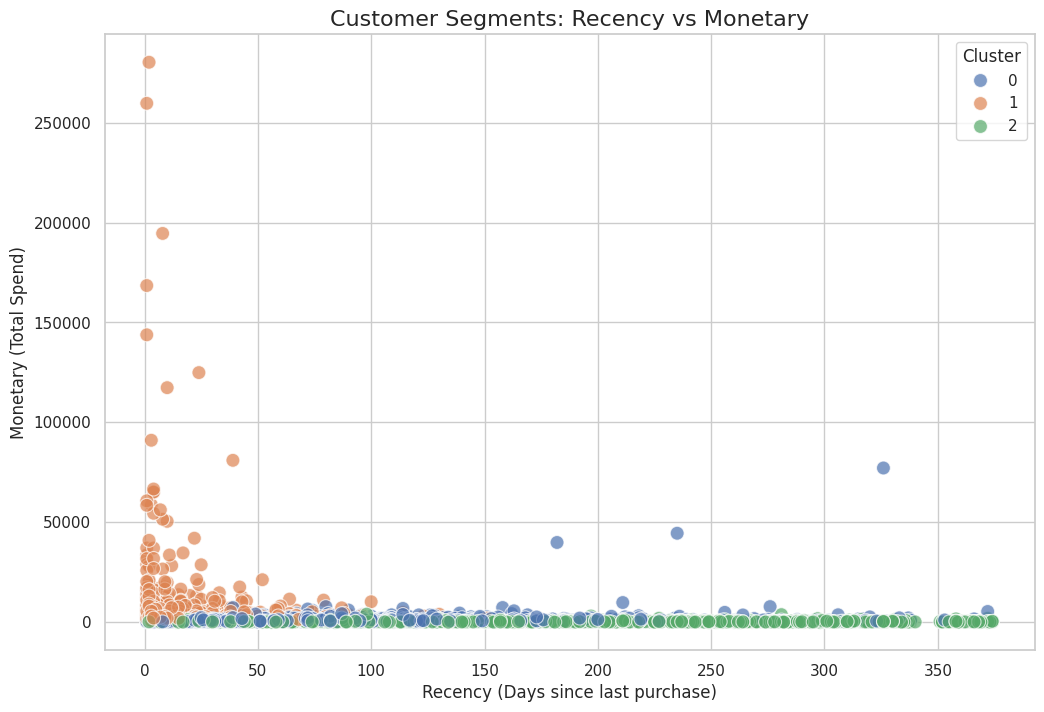

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Plot Recency vs Monetary, colored by Cluster
# We use 'hue' to color by Cluster and 'palette' for color scheme
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='deep',
    s=100,  # size of dots
    alpha=0.7 # transparency
)

plt.title('Customer Segments: Recency vs Monetary', fontsize=16)
plt.xlabel('Recency (Days since last purchase)', fontsize=12)
plt.ylabel('Monetary (Total Spend)', fontsize=12)
plt.legend(title='Cluster')
plt.show()

Interactive 3-D plot

In [8]:
import plotly.express as px

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    rfm,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    opacity=0.7,
    size_max=10,
    title='3D Customer Segmentation (RFM)',
    template='plotly_dark' # Looks cool for portfolios
)

# Show the plot
fig.show()

In [9]:
# Save the dataframe with the Cluster labels
rfm.to_csv('rfm_segmented_customers.csv', index=True)
print("File saved! Check the files tab on the left to download.")

File saved! Check the files tab on the left to download.
